<h1 align=center><font size = 5>SPE Europe Energy GeoHackathon</font></h1>

Society of Petroleum Engieers|  ERCE Equipoise | Geothermal Challenge  
:-------------------------:|:-------------------------:|:-------------------------:
<a href="https://www.spehackathon-eu.com"> <img src = "https://upload.wikimedia.org/wikipedia/en/thumb/4/42/Society_of_Petroleum_Engineers_Logo.svg/1200px-Society_of_Petroleum_Engineers_Logo.svg.png" width = 200 /> | <a href="https://www.erce.energy/"> <img src = "https://energycouncil.com/wp-content/uploads/ERCE.png" width = 200/> | <img src = "https://solutions.vallourec.com/-/media/Solutions-img/Low-Carbon-Energy/Medias/Geothermal-energy/Header-Corner_Geothermal.ashx" width = 200/>
    


<h1 align=center><font size = 4> Team ERCE - Munish Kumar, Kanna Swaminathan & Ivan Maulana </font></h1>
<h1 align=center><font size = 3> 2021 </font></h1>

In [1]:
from IPython.display import HTML, display
from IPython.display import Image

# To use, just type set_background('XXX') where XXX is whatever colour you want
def set_background(color):         
    script = ("var cell = this.closest('.code_cell');" 
              "var editor = cell.querySelector('.input_area');"         
              "editor.style.background='{}';"         
              "this.parentNode.removeChild(this)"     
             ).format(color)      
    display(HTML('<img src onerror="{}">'.format(script)))

In [2]:
set_background('purple')

In [3]:
# Only uncomment if none of the following is installed

#!conda install -c anaconda scikit-learn --yes
#!conda install -c anaconda scipy --yes
#!conda install -c anaconda dash --yes
#!conda install -c anaconda plotly --yes
#!conda install -c anaconda multiprocess --yes
#!conda install -c anaconda nltk --yes
#!conda install -c https://conda.anaconda.org/conda-forge wordcloud --yes
#!conda install -c conda-forge textblob --yes
#!conda install -c districtdatalabs yellowbrick --yes

In [4]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import seaborn as sns
import math

import time
import re
import requests
import pickle
import os
import glob
import scipy
import sys
import warnings

import plotly.express as px
import plotly.graph_objects as go 

# Sklearn & NLP libraries
#from sklearn import preprocessing
#import nltk
#from nltk import FreqDist
#from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer # Preprocessing - Stemming
#from textblob import TextBlob #spelling corrections
#from textblob import Word # Preprocessing - Lematization 
#from wordcloud import WordCloud, STOPWORDS
#from yellowbrick.text import TSNEVisualizer
# Word Embedding + ML libraries

#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  #Word embedding
#from sklearn import model_selection, linear_model, naive_bayes, ensemble, metrics, preprocessing  # different ML
#from xgboost import XGBClassifier #ML algo

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set()

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [5]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Working\SPE_GeoHackathon\Data'
filename_suffix = 'txt'
filename_suffix2 = 'csv'

Function to read multiple text files and process for static properties

In [6]:
def interp_well(dir_name, base_filename, filename_suffix):
    skiprows = 3
    base_filename = base_filename
    csvs_sht = os.path.join(dir_name, base_filename + '.' + filename_suffix)

    data = pd.read_csv(csvs_sht, delimiter = "\t", skiprows = skiprows, header=None)
    data.columns = ["Depth (m)", "Transit Time (micron/sec)"]
        
    #Check the data
    print("------------------Checking the Data---------------")   
    print(data.head())
    print("------------------Type of Data---------------")   
    print(data.info())
    print("------------------Checking for missing points visually---------------")   
    
    fig, ax = plt.subplots(figsize=(25,8))
    sns.heatmap(data.isnull(), ax=ax, cmap="magma")
    plt.grid()
    plt.show()

    # 3 functions. 
    # 1. Function "calc_poro" evaluates porosity
    # 2. Function "crossplot2" create visual of evaluation
    # 3. Function "calc_poro" evaluates porosity
    log_df = calc_poro(data)
    crossplot2(log_df)
  
    print("------------------Export Stats of Relevance---------------")
    max_pu = 0.45
    log_df_stats = filter_for_stats(log_df,max_pu)
    
    print("------------------Writing out the file---------------") 
    csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix2)
    log_df_stats.to_csv(csvs_sht, index = True, header=True)
    print ("Final File Extract Produced") 
    
    return

In [7]:
# Porosity based on Raymer Hunt Gardner
def calc_poro(data):
    
    DT = data["Transit Time (micron/sec)"][1:].apply(pd.to_numeric).reset_index(drop = True)
    
    # Assume sandstone. DT_MASD is delta time of quartz and DT_F is delta fime of fluid
    # B is a compaction factor
    DT_F = 191
    DT_MASD = 56
    Cp = 240/100 # Assume 240 us/m is shale transit time
    
    # Wyllie Porosity 
    PHIA = ((DT - DT_MASD)/(DT_F - DT_MASD))*(1/Cp)
    
    data.drop(index=data.index[0], axis=0, inplace=True)
    
    data['Porosity (V/V)'] = PHIA
    data = data.apply(pd.to_numeric)
    return data   

In [8]:
def crossplot2(log_df):
    print("------------------Data set for visualisation---------------")
    print(log_df.head())
    print("------------------Descriptive Statistics for Data set---------------")    
    print(log_df.describe())
    
    fig, ax = plt.subplots(figsize=(10,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax7 = ax1.twiny()
    ax7.xaxis.set_visible(False)
    ax8 = ax2.twiny()
    ax8.xaxis.set_visible(False)

    # Sonic track
    ax1.plot('Transit Time (micron/sec)', 'Depth (m)', data = log_df, color = "purple")
    ax1.set_xlabel("Sonic")
    ax1.set_xlim(440, 40)
    ax1.xaxis.label.set_color("purple")
    ax1.tick_params(axis='x', colors="purple")
    ax1.spines["top"].set_edgecolor("purple")
    ax1.set_xticks([440, 340, 240, 140, 40])

    # Porosity track placed ontop of density track
    ax2.plot("Porosity (V/V)", "Depth (m)", data = log_df, color = "blue")
    ax2.set_xlabel('Porosity')
    ax2.xaxis.label.set_color("blue")
    ax2.set_xlim(0.7, 0)
    #ax2.set_ylim(4850, 4600)
    ax2.tick_params(axis='x', colors="blue")
    ax2.spines["top"].set_position(("axes", 1.08))
    ax2.spines["top"].set_visible(True)
    ax2.spines["top"].set_edgecolor("blue")
    ax2.set_xticks([0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
    
    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2]:
        #ax.set_ylim(2400, 2300)Depth (m)
        ax.set_ylim(np.min(log_df['Depth (m)']), np.max(log_df['Depth (m)']))
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))  
    
    plt.tight_layout()
    plt.show()
    return

In [9]:
def filter_for_stats(log_df, max_pu):     
    df_sst = log_df[log_df["Porosity (V/V)"] <= max_pu]
    print(df_sst.describe())
    return df_sst.describe()

#### The following code evaluates the static properties. The input file does not provide any stratigraphic tops or gamma ray log. Only a sonic log was provided

#### Therefore, the assumption we are making are
1. That this entire log is only across the reservoir section
2. That this is a sandstone reservoir (with shale breaks in between the sands)
3. That the well is vertical
4. That high porosity values are for shales; sandstone porosity is naturally limited to max case of 0.45 p.u.

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2308.8300                  237.915924
2  2308.9439                  237.084505
3  2309.0579                  235.747799
4  2309.1718                  238.900018
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


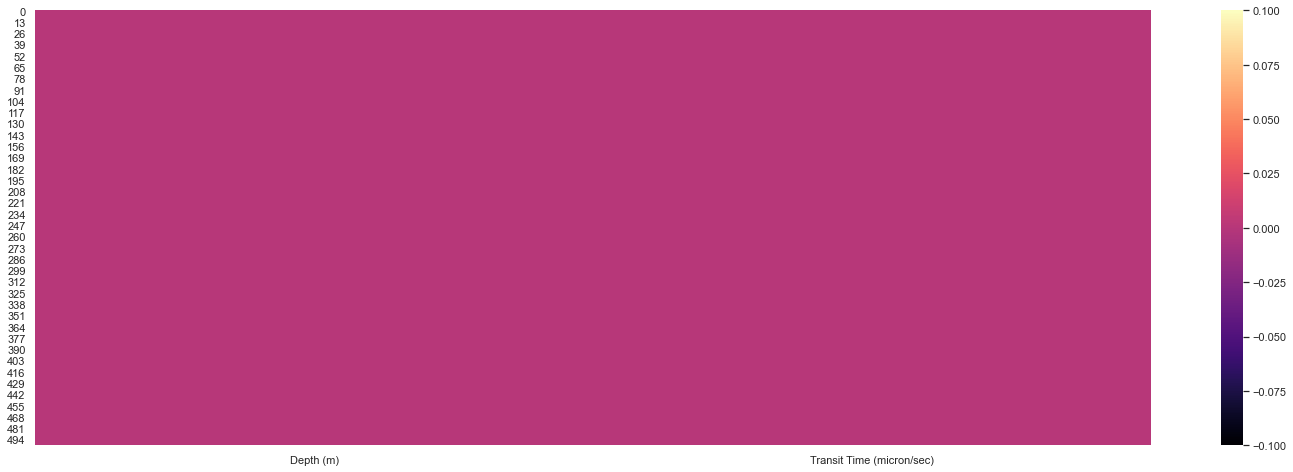

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2308.8300                 237.915924        0.558903
2  2308.9439                 237.084505        0.554777
3  2309.0579                 235.747799        0.564506
4  2309.1718                 238.900018        0.552364
5  2309.2858                 234.965882        0.549870
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      499.000000
mean   2337.260000                 238.920474        0.564576
std      16.463401                  25.094963        0.077531
min    2308.830000                 179.726306        0.381871
25%    2323.045000                 213.544965        0.485311
50%    2337.260000                 244.401803        0.581638
75%    2351.475000                 254.710681        0.613509
max    2365.690000                 280.

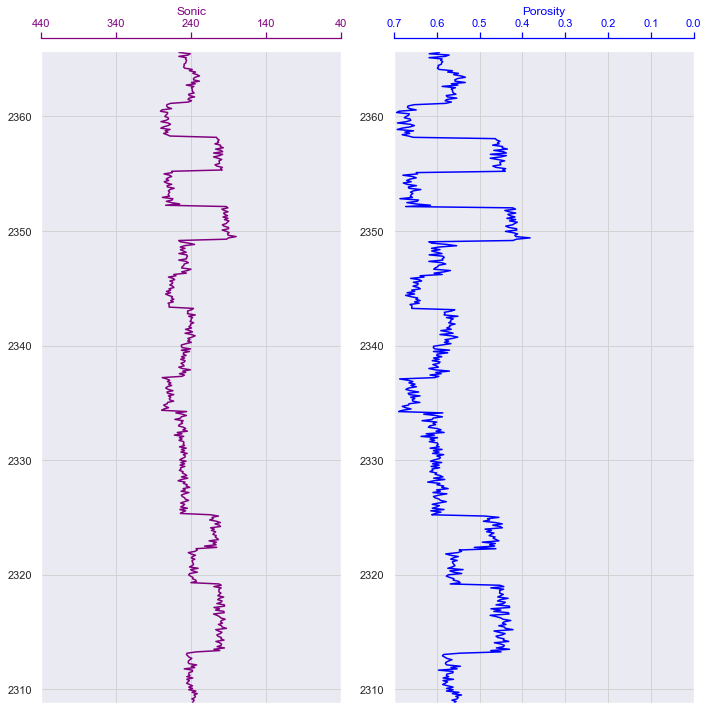

------------------Export Stats of Relevance---------------
        Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count    65.00000                  65.000000       65.000000
mean   2336.26340                 200.884557        0.432565
std      18.10917                  13.402977        0.012982
min    2313.27400                 179.726306        0.381871
25%    2316.12270                 193.025555        0.422470
50%    2349.50940                 198.470598        0.436100
75%    2351.33260                 203.482389        0.442920
max    2357.37180                 265.934574        0.449780
------------------Writing out the file---------------
Final File Extract Produced


In [10]:
df1 = interp_well(dir_name, 'E01_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2027.9900                  234.568691
2  2028.4132                  232.559050
3  2028.8364                  222.612878
4  2029.2596                  236.378002
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


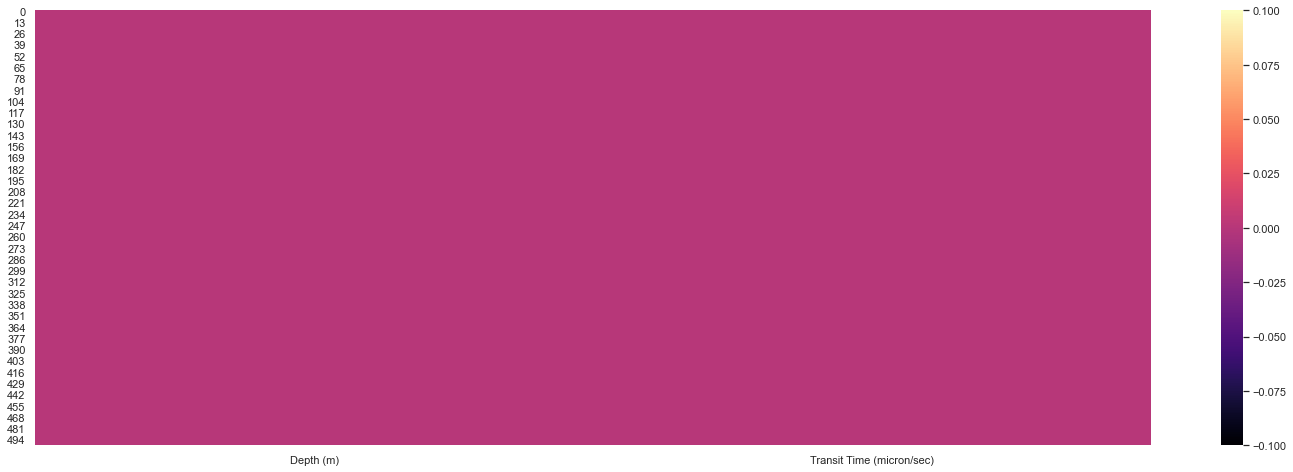

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2027.9900                 234.568691        0.544935
2  2028.4132                 232.559050        0.514237
3  2028.8364                 222.612878        0.556722
4  2029.2596                 236.378002        0.534705
5  2029.6828                 229.244282        0.531539
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      499.000000
mean   2133.580000                 243.140640        0.577648
std      61.145638                  13.188465        0.040729
min    2027.990000                 205.503390        0.461430
25%    2080.785000                 237.053276        0.559004
50%    2133.580000                 243.931912        0.580175
75%    2186.375000                 250.428316        0.600312
max    2239.170000                 278.

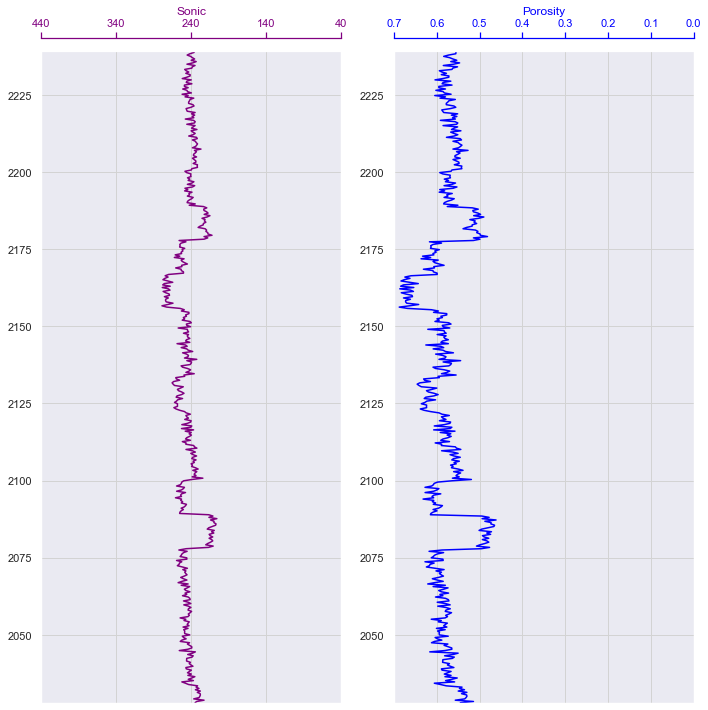

------------------Export Stats of Relevance---------------
       Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count        0.0                        0.0             0.0
mean         NaN                        NaN             NaN
std          NaN                        NaN             NaN
min          NaN                        NaN             NaN
25%          NaN                        NaN             NaN
50%          NaN                        NaN             NaN
75%          NaN                        NaN             NaN
max          NaN                        NaN             NaN
------------------Writing out the file---------------
Final File Extract Produced


In [11]:
df2 = interp_well(dir_name, 'E03_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  1842.9300                  241.527030
2  1843.2070                  230.261838
3  1843.4840                  230.738602
4  1843.7610                  235.578155
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


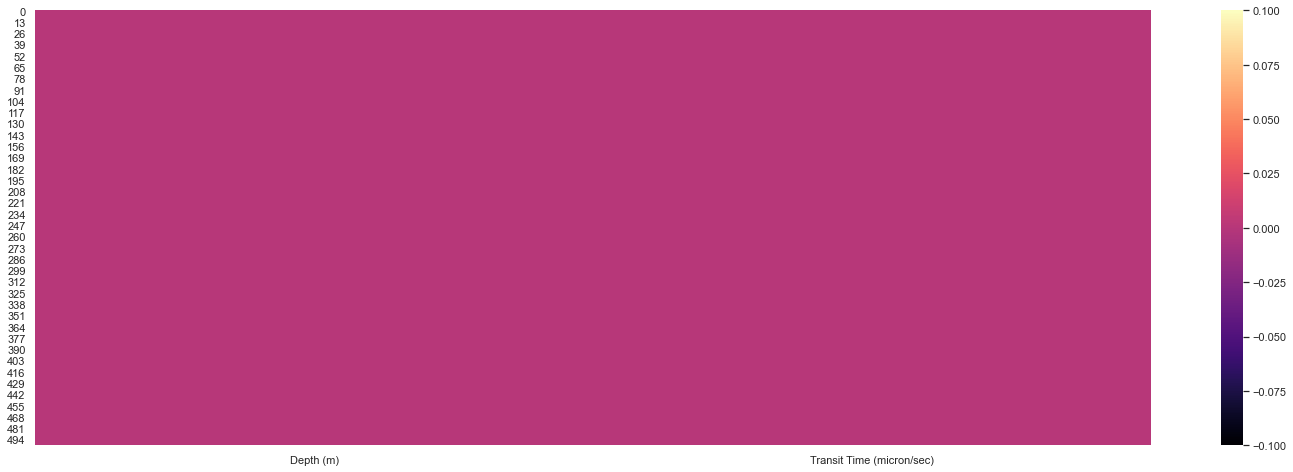

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1   1842.930                 241.527030        0.537845
2   1843.207                 230.261838        0.539317
3   1843.484                 230.738602        0.554254
4   1843.761                 235.578155        0.566276
5   1844.038                 239.473500        0.562977
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      499.000000
mean   1912.040000                 231.364325        0.541185
std      40.020599                  22.507715        0.069524
min    1842.930000                 178.909434        0.379350
25%    1877.484975                 210.800743        0.477531
50%    1912.040000                 236.145272        0.555961
75%    1946.595025                 247.872491        0.592347
max    1981.150000                 273.

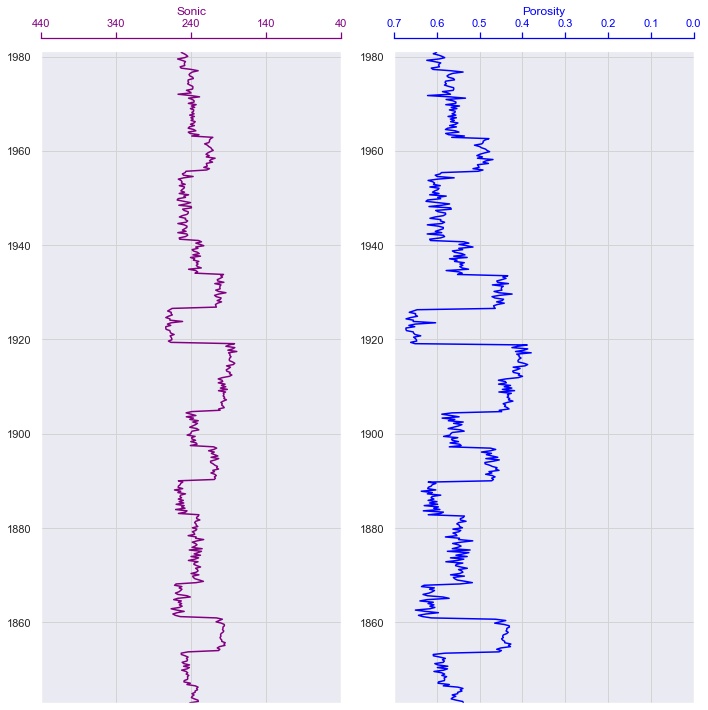

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count    81.000000                  81.000000       81.000000
mean   1901.502259                 196.233672        0.427543
std      26.630601                   8.071017        0.017652
min    1854.009800                 178.909434        0.379350
25%    1904.699700                 190.803157        0.413203
50%    1911.070500                 197.069939        0.432473
75%    1916.887400                 200.744200        0.441618
max    1933.507000                 239.004927        0.449287
------------------Writing out the file---------------
Final File Extract Produced


In [12]:
df3 = interp_well(dir_name, 'E05_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2017.7900                  232.763285
2  2017.8581                  233.375255
3  2017.9262                  225.447232
4  2017.9943                  237.962389
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


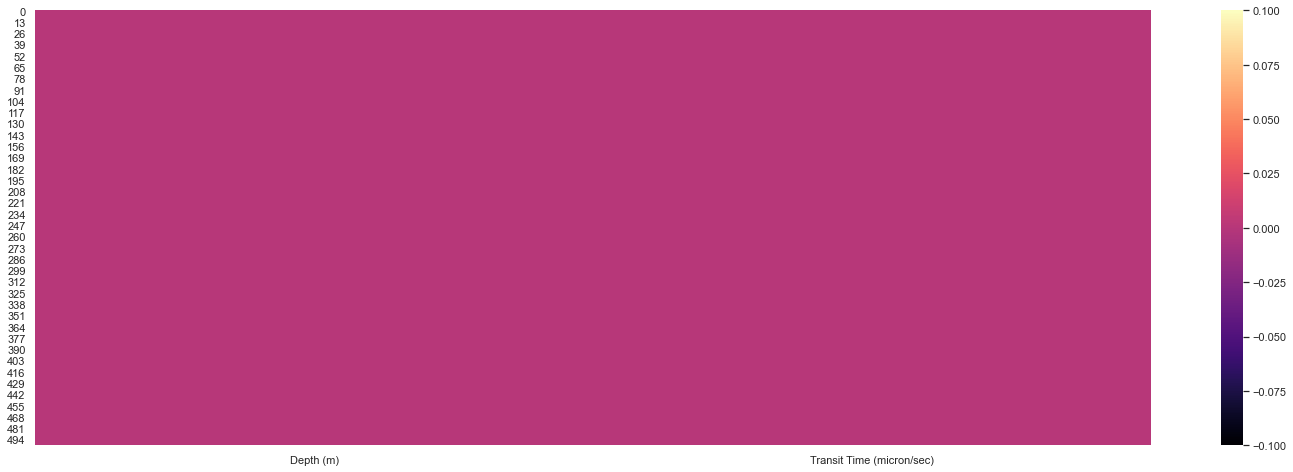

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2017.7900                 232.763285        0.547454
2  2017.8581                 233.375255        0.522985
3  2017.9262                 225.447232        0.561612
4  2017.9943                 237.962389        0.553959
5  2018.0625                 235.482800        0.568180
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      499.000000
mean   2034.785000                 252.330882        0.606081
std       9.841559                  13.570179        0.041838
min    2017.790000                 215.666302        0.492797
25%    2026.287475                 242.146657        0.574760
50%    2034.785000                 254.386190        0.612437
75%    2043.282525                 263.219205        0.639584
max    2051.780000                 279.

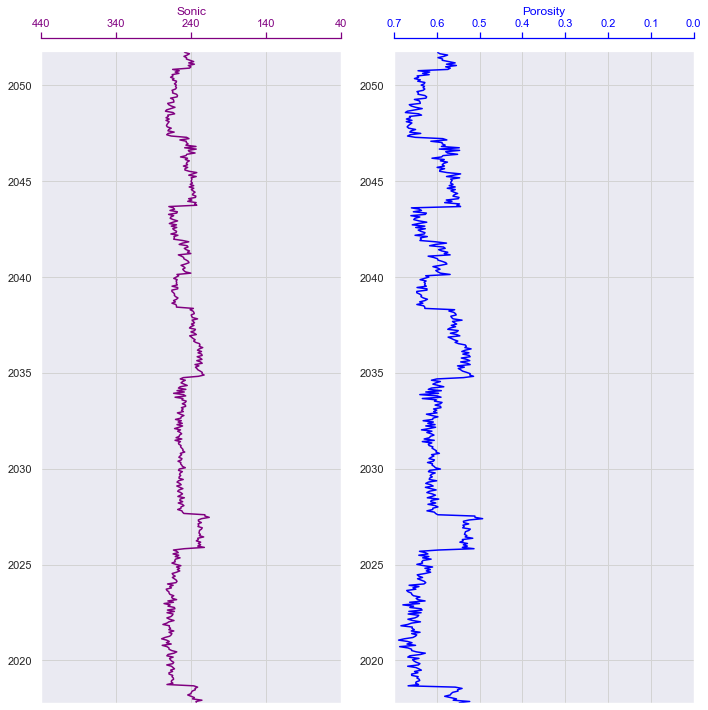

------------------Export Stats of Relevance---------------
       Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count        0.0                        0.0             0.0
mean         NaN                        NaN             NaN
std          NaN                        NaN             NaN
min          NaN                        NaN             NaN
25%          NaN                        NaN             NaN
50%          NaN                        NaN             NaN
75%          NaN                        NaN             NaN
max          NaN                        NaN             NaN
------------------Writing out the file---------------
Final File Extract Produced


In [13]:
df4 = interp_well(dir_name, 'I02_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  1974.9600                  220.479739
2  1975.3006                  215.669687
3  1975.6412                  209.846644
4  1975.9818                  217.550213
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


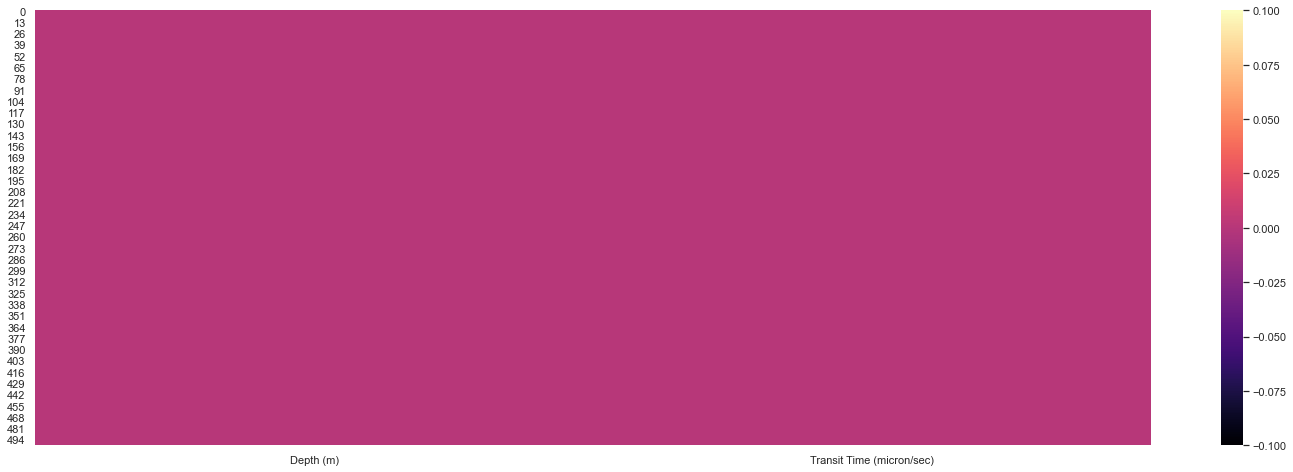

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  1974.9600                 220.479739        0.492808
2  1975.3006                 215.669687        0.474835
3  1975.6412                 209.846644        0.498612
4  1975.9818                 217.550213        0.506125
5  1976.3224                 219.984475        0.502435
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      499.000000
mean   2059.940000                 236.960773        0.558623
std      49.210688                  19.385963        0.059850
min    1974.960000                 192.052272        0.419914
25%    2017.450025                 225.388543        0.522918
50%    2059.940000                 234.924565        0.552274
75%    2102.429975                 248.501820        0.594337
max    2144.920000                 287.

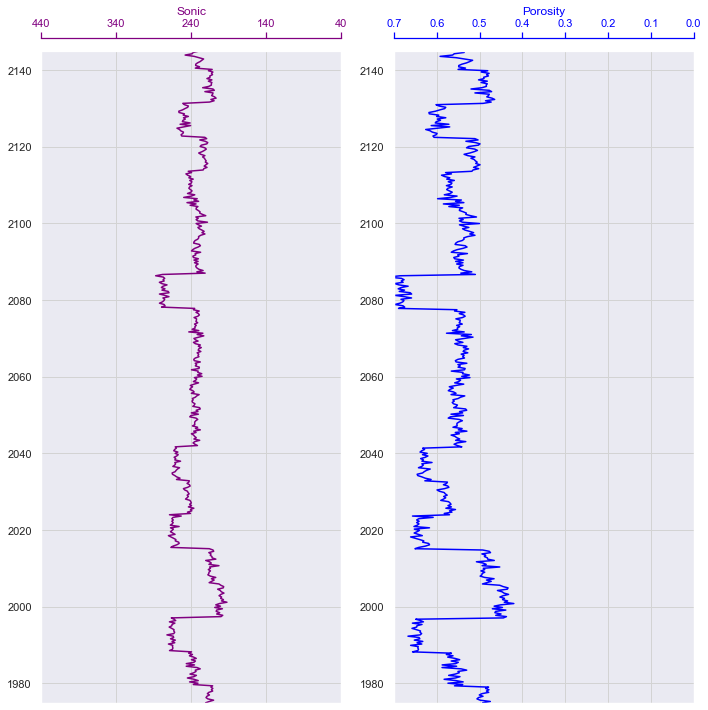

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count    17.000000                  17.000000       17.000000
mean   2001.627076                 204.306300        0.440131
std       2.587677                  16.512142        0.007465
min    1997.099100                 192.052272        0.419914
25%    1999.823900                 196.966776        0.435083
50%    2001.867500                 200.179563        0.442298
75%    2003.570500                 204.452540        0.445060
max    2005.273500                 266.310138        0.449786
------------------Writing out the file---------------
Final File Extract Produced


In [14]:
df5 = interp_well(dir_name, 'I03_welllogs', filename_suffix)

------------------Checking the Data---------------
   Depth (m)   Transit Time (micron/sec)
0   depth(m)   transit time (micron/sec)
1  2267.7400                  246.781006
2  2267.9080                  240.362193
3  2268.0760                  237.344548
4  2268.2439                  241.465081
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Depth (m)                  501 non-null    object
 1   Transit Time (micron/sec)  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB
None
------------------Checking for missing points visually---------------


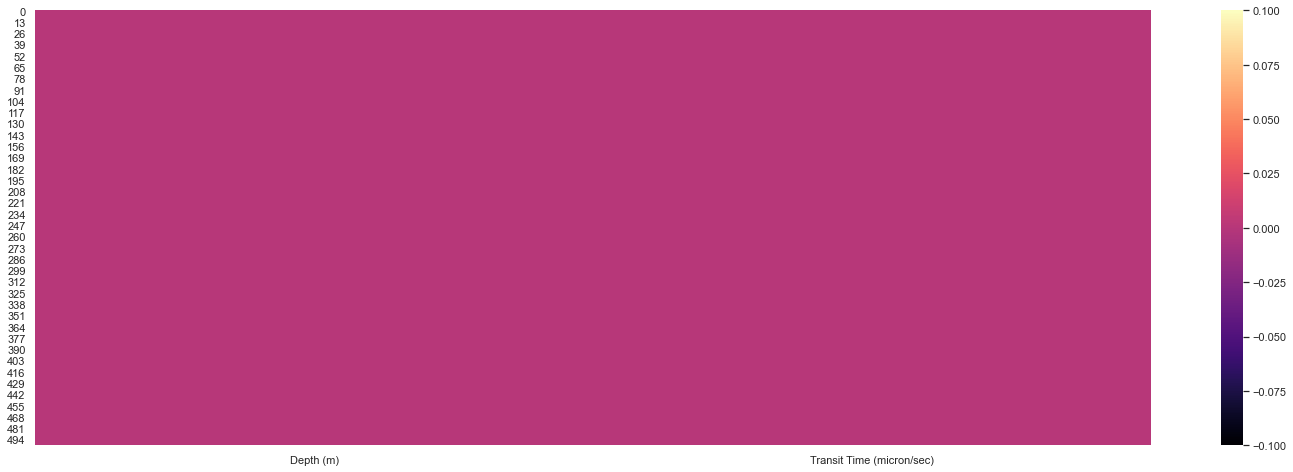

------------------Data set for visualisation---------------
   Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
1  2267.7400                 246.781006        0.569019
2  2267.9080                 240.362193        0.559705
3  2268.0760                 237.344548        0.572423
4  2268.2439                 241.465081        0.560603
5  2268.4119                 237.635330        0.542290
------------------Descriptive Statistics for Data set---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count   500.000000                 500.000000      499.000000
mean   2309.650000                 244.009199        0.580258
std      24.269473                  24.701907        0.076316
min    2267.740000                 161.839060        0.326664
25%    2288.695000                 231.176010        0.540569
50%    2309.650000                 245.377702        0.584390
75%    2330.605000                 261.864776        0.635529
max    2351.560000                 284.

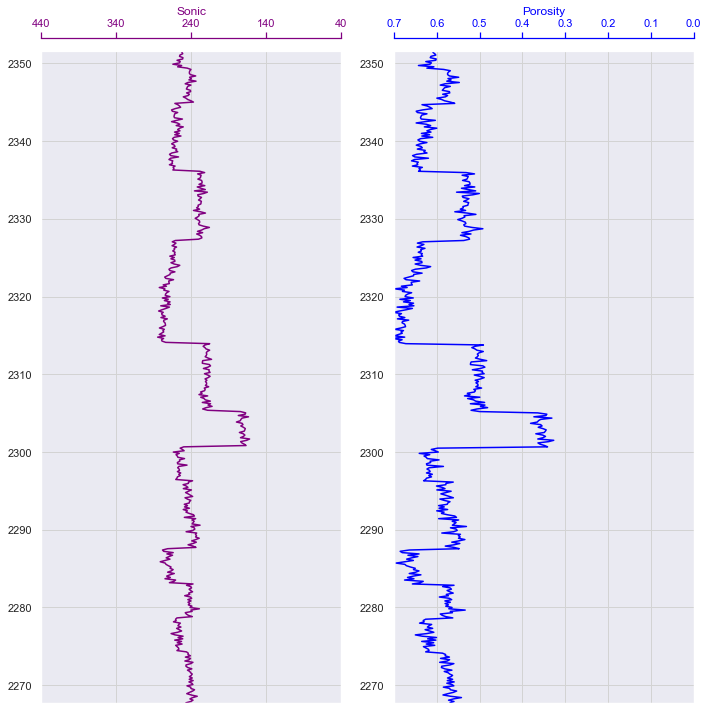

------------------Export Stats of Relevance---------------
         Depth (m)  Transit Time (micron/sec)  Porosity (V/V)
count    27.000000                  27.000000       27.000000
mean   2302.846974                 173.363546        0.353574
std       1.333272                  15.772549        0.012529
min    2300.663300                 161.839060        0.326664
25%    2301.755100                 167.913418        0.345412
50%    2302.847000                 170.233119        0.352571
75%    2303.938800                 173.693590        0.363252
max    2305.030700                 249.701565        0.380842
------------------Writing out the file---------------
Final File Extract Produced


In [15]:
df5 = interp_well(dir_name, 'P01_welllogs', filename_suffix)

### Conclusion

In [16]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 5.085397720336914 seconds
